In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import HTML; 
display(HTML("<style>.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {padding: 0; border: 0;}</style>"));

In [3]:
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [4]:
scoresheet = pd.read_csv('srp_ridge_results_processed.csv')

In [5]:
scoresheet.groupby(['training']).size().reset_index().rename(columns={0:'count'})

,training,count
0,deepcluster,509047
1,imagenet,10822207
2,random,10822207
3,taskonomy,24632586


In [6]:
taskonomy_scoresheet = scoresheet[scoresheet['training'] == 'taskonomy']
imagenet_scoresheet = scoresheet[(scoresheet['training'] == 'imagenet') | (scoresheet['training'] == 'random')]

In [151]:
cell_data = pd.read_csv('cell_data_merge.csv')

In [338]:
task_definitions = pd.read_csv('taskonomy_2020/task_definitions.csv')

### Model Hierarchy by Top Model Status per Neuron

In [7]:
total_neuron_count = (scoresheet.groupby(['brain_area', 'brain_layer', 'neuron'])
                      .size().reset_index().rename(columns={0:'count'}).shape[0])

In [8]:
top_model_status = (scoresheet[scoresheet.groupby(['brain_area', 'brain_layer','neuron'])['score']
                               .transform(max) == scoresheet['score']].sort_values(by='neuron')['model_string']
                    .value_counts().reset_index().rename(columns={'index':'model_string','model_string':'count'}))
top_model_status['model'] = top_model_status['model_string'].apply(lambda x: '_'.join(x.split('_')[:-1]))
top_model_status['training'] = top_model_status['model_string'].apply(lambda x: x.split('_')[-1])
top_model_status['proportion'] = top_model_status['count'] / total_neuron_count
top_model_status = top_model_status[['model', 'training', 'count', 'proportion']]

In [9]:
top_model_status['count'].sum(), total_neuron_count

(6634, 6611)

In [10]:
top_model_status.head()

,model,training,count,proportion
0,densenet161,imagenet,897,0.135683
1,resnet152,imagenet,665,0.100590
2,keypoints2d,taskonomy,521,0.078808
3,vanishing_point,taskonomy,330,0.049917
4,autoencoding,taskonomy,289,0.043715


In [11]:
top_model_status.tail()

,model,training,count,proportion
40,resnet50,random,24,0.003630
41,resnet18,random,22,0.003328
42,mnasnet1_0,random,21,0.003177
43,vgg16,random,17,0.002571
44,vgg16_bn,random,9,0.001361


In [12]:
top_model_status['count'].sum()

6634

In [15]:
pg.ttest(top_model_status[top_model_status['training'] == 'taskonomy']['proportion'],
         top_model_status[top_model_status['training'] == 'random']['proportion'])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.350082,27.07302,two-sided,0.000173,"[0.01, 0.02]",1.132799,155.44,0.825583


In [16]:
pg.ttest(top_model_status[top_model_status['training'] == 'taskonomy']['proportion'],
         top_model_status[top_model_status['training'] == 'imagenet']['proportion'])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.19624,10.246277,two-sided,0.25855,"[-0.05, 0.01]",0.617105,0.601,0.351731


In [17]:
pg.ttest(top_model_status[top_model_status['training'] == 'taskonomy']['proportion'],
         top_model_status[top_model_status['training'] != 'taskonomy']['proportion'])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.047004,31.298757,two-sided,0.962809,"[-0.02, 0.02]",0.014201,0.295,0.050248


In [18]:
top_task_status = (taskonomy_scoresheet[taskonomy_scoresheet.groupby(['brain_area', 'brain_layer','neuron'])['score']
                               .transform(max) == taskonomy_scoresheet['score']].sort_values(by='neuron')['model_string']
                    .value_counts().reset_index().rename(columns={'index':'model_string','model_string':'count'}))
top_task_status['task'] = top_task_status['model_string'].apply(lambda x: '_'.join(x.split('_')[:-1]))
top_task_status['training'] = top_task_status['model_string'].apply(lambda x: x.split('_')[-1])
top_task_status['proportion'] = top_task_status['count'] / total_neuron_count
top_task_status = top_task_status[['task', 'training', 'count', 'proportion']]

In [19]:
top_task_status

,task,training,count,proportion
0,keypoints2d,taskonomy,801,0.121162
1,vanishing_point,taskonomy,619,0.093632
2,edge_texture,taskonomy,561,0.084859
3,autoencoding,taskonomy,466,0.070489
4,class_object,taskonomy,424,0.064136
5,segment_semantic,taskonomy,395,0.059749
6,class_scene,taskonomy,384,0.058085
7,segment_unsup2d,taskonomy,334,0.050522
8,curvature,taskonomy,246,0.037211
9,jigsaw,taskonomy,242,0.036606


In [20]:
top_arch_status = (imagenet_scoresheet[imagenet_scoresheet.groupby(['brain_area', 'brain_layer','neuron'])['score']
                               .transform(max) == imagenet_scoresheet['score']].sort_values(by='neuron')['model_string']
                    .value_counts().reset_index().rename(columns={'index':'model_string','model_string':'count'}))
top_arch_status['model'] = top_arch_status['model_string'].apply(lambda x: '_'.join(x.split('_')[:-1]))
top_arch_status['training'] = top_arch_status['model_string'].apply(lambda x: x.split('_')[-1])
top_arch_status['proportion'] = top_arch_status['count'] / total_neuron_count
top_arch_status = top_arch_status[['model', 'training', 'count', 'proportion']]

In [21]:
top_arch_status

,model,training,count,proportion
0,densenet161,imagenet,1861,0.281501
1,resnet152,imagenet,1410,0.213281
2,mnasnet1_0,imagenet,438,0.066253
3,resnet50,imagenet,394,0.059598
4,mobilenet_v2,imagenet,369,0.055816
5,squeezenet1_0,imagenet,306,0.046286
6,densenet161,random,247,0.037362
7,resnet152,random,201,0.030404
8,alexnet,imagenet,196,0.029648
9,vgg16_bn,imagenet,184,0.027832


In [22]:
pg.ttest(top_arch_status[top_arch_status['training'] == 'imagenet']['proportion'],
         top_arch_status[top_arch_status['training'] == 'random']['proportion'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.556857,9,two-sided,0.030846,"[0.01, 0.12]",1.017698,2.551,0.816448


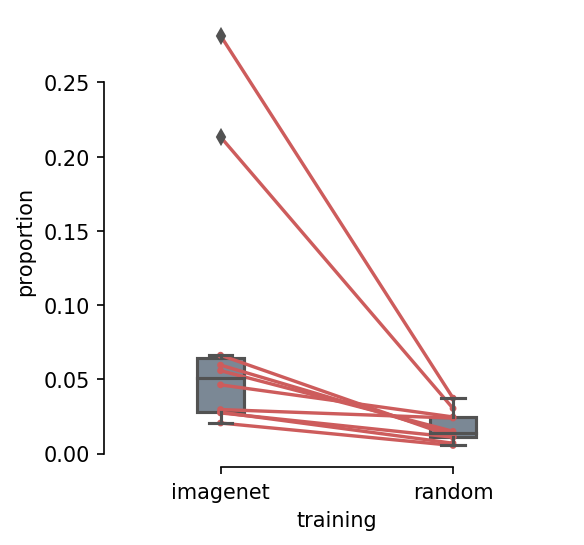

In [23]:
pg.plot_paired(data=top_arch_status.query("training == 'random' or training == 'imagenet'"), dv='proportion', 
                                                within='training', subject='model', dpi=150);

In [24]:
top_model_status.to_csv('top_model_status_ridge.csv', index = None)
top_task_status.to_csv('top_task_status_ridge.csv', index = None)
top_arch_status.to_csv('top_arch_status_ridge.csv', index = None)

### Top Model Status By Neuron By Site

In [265]:
#neural_count_bysite = cell_data.groupby(['area','layer'])['cell_specimen_id'].nunique().reset_index()
neural_count_bysite = (scoresheet.groupby(['brain_area','brain_layer'])['cell_specimen_id'].nunique()
                       .reset_index().rename(columns={'cell_specimen_id': 'neuron_count'}))

neural_count_byarea = (scoresheet.groupby(['brain_area'])['cell_specimen_id'].nunique()
                       .reset_index().rename(columns={'cell_specimen_id': 'neuron_count'}))

In [292]:
neural_count_byarea

,brain_area,neuron_count
0,VISal,764
1,VISam,149
2,VISl,1920
3,VISp,3254
4,VISpm,455
5,VISrl,69


In [339]:
neural_count_bysite_dict = neural_count_bysite.set_index(['brain_area','brain_layer']).to_dict(orient='index')

top_task_status_bysite = (taskonomy_scoresheet[taskonomy_scoresheet.groupby(['brain_area', 'brain_layer','neuron'])['score']
                               .transform(max) == taskonomy_scoresheet['score']].sort_values(by='neuron')
                          .groupby(['brain_area','brain_layer','model'])
                          .size().reset_index().rename(columns={0: 'count'}))

def get_neuron_count_bysite(brain_area, brain_layer):
    return neural_count_bysite_dict[(brain_area, brain_layer)]['neuron_count']

top_task_status_bysite['proportion'] = (top_task_status_bysite
                                        .apply(lambda x: x['count'] / 
                                               get_neuron_count_bysite(x['brain_area'],x['brain_layer']), axis = 1))

top_task_status_bysite = top_task_status_bysite.merge(task_definitions, on='model')

#(top_task_status_bysite['count'] /  top_task_status_bysite.groupby(['brain_layer', 'brain_area'])['count'].transform("sum"))

In [318]:
top_task_status_bysite['count'].sum()

6611

In [340]:
top_task_status_bysite.groupby(['brain_area','brain_layer'])['proportion'].sum()

brain_area  brain_layer
VISal       layer23        1.0
            layer4         1.0
            layer5         1.0
VISam       layer23        1.0
            layer4         1.0
            layer5         1.0
VISl        layer23        1.0
            layer4         1.0
            layer5         1.0
            layer6         1.0
VISp        layer23        1.0
            layer4         1.0
            layer5         1.0
            layer6         1.0
VISpm       layer23        1.0
            layer4         1.0
            layer5         1.0
            layer6         1.0
VISrl       layer23        1.0
            layer4         1.0
            layer5         1.0
Name: proportion, dtype: float64

In [347]:
#top_task_status_bysite.to_csv('top_task_status_bysite.csv', index = None)

In [342]:
neural_count_byarea_dict = neural_count_byarea.set_index(['brain_area']).to_dict(orient='index')

top_task_status_byarea = (taskonomy_scoresheet[taskonomy_scoresheet.groupby(['brain_area','brain_layer','neuron'])['score']
                               .transform(max) == taskonomy_scoresheet['score']].sort_values(by='neuron')
                          .groupby(['brain_area','model'])
                          .size().reset_index().rename(columns={0: 'count'}))

def get_neuron_count_byarea(brain_area):
    return neural_count_byarea_dict[brain_area]['neuron_count']

top_task_status_byarea['proportion'] = (top_task_status_byarea
                                        .apply(lambda x: x['count'] / 
                                               get_neuron_count_byarea(x['brain_area']), axis = 1))

top_task_status_byarea = top_task_status_byarea.merge(task_definitions, on='model')

In [348]:
top_task_status_byarea.groupby(['brain_area'])['proportion'].sum()

brain_area
VISal    1.0
VISam    1.0
VISl     1.0
VISp     1.0
VISpm    1.0
VISrl    1.0
Name: proportion, dtype: float64

In [336]:
#top_task_status_byarea.to_csv('top_task_status_byarea.csv', index = None)

In [128]:
top_task_status_bysite.groupby('brain_area')['count'].sum()

brain_area
VISal     426
VISam      87
VISl      989
VISp     1645
VISpm     229
VISrl      42
Name: count, dtype: int64

In [252]:
top_task_status_bysite

,brain_area,brain_layer,model,count,proportion
0,VISal,layer23,autoencoding,16,0.081633
1,VISal,layer23,class_object,17,0.086735
2,VISal,layer23,class_scene,15,0.076531
3,VISal,layer23,curvature,6,0.030612
4,VISal,layer23,denoising,4,0.020408
...,...,...,...,...,...
385,VISrl,layer4,segment_unsup2d,3,0.120000
386,VISrl,layer4,vanishing_point,1,0.040000
387,VISrl,layer5,class_object,1,0.333333
388,VISrl,layer5,segment_semantic,1,0.333333


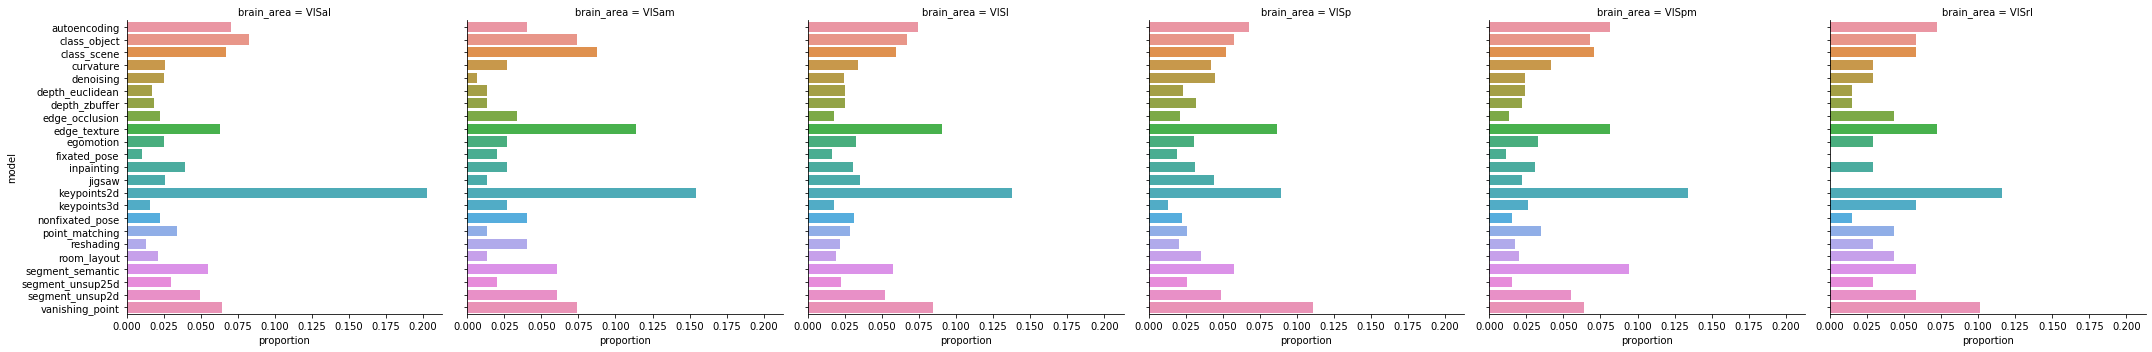

In [349]:
sns.catplot(x='proportion', y='model', kind='bar', col = 'brain_area', data=top_task_status_byarea);

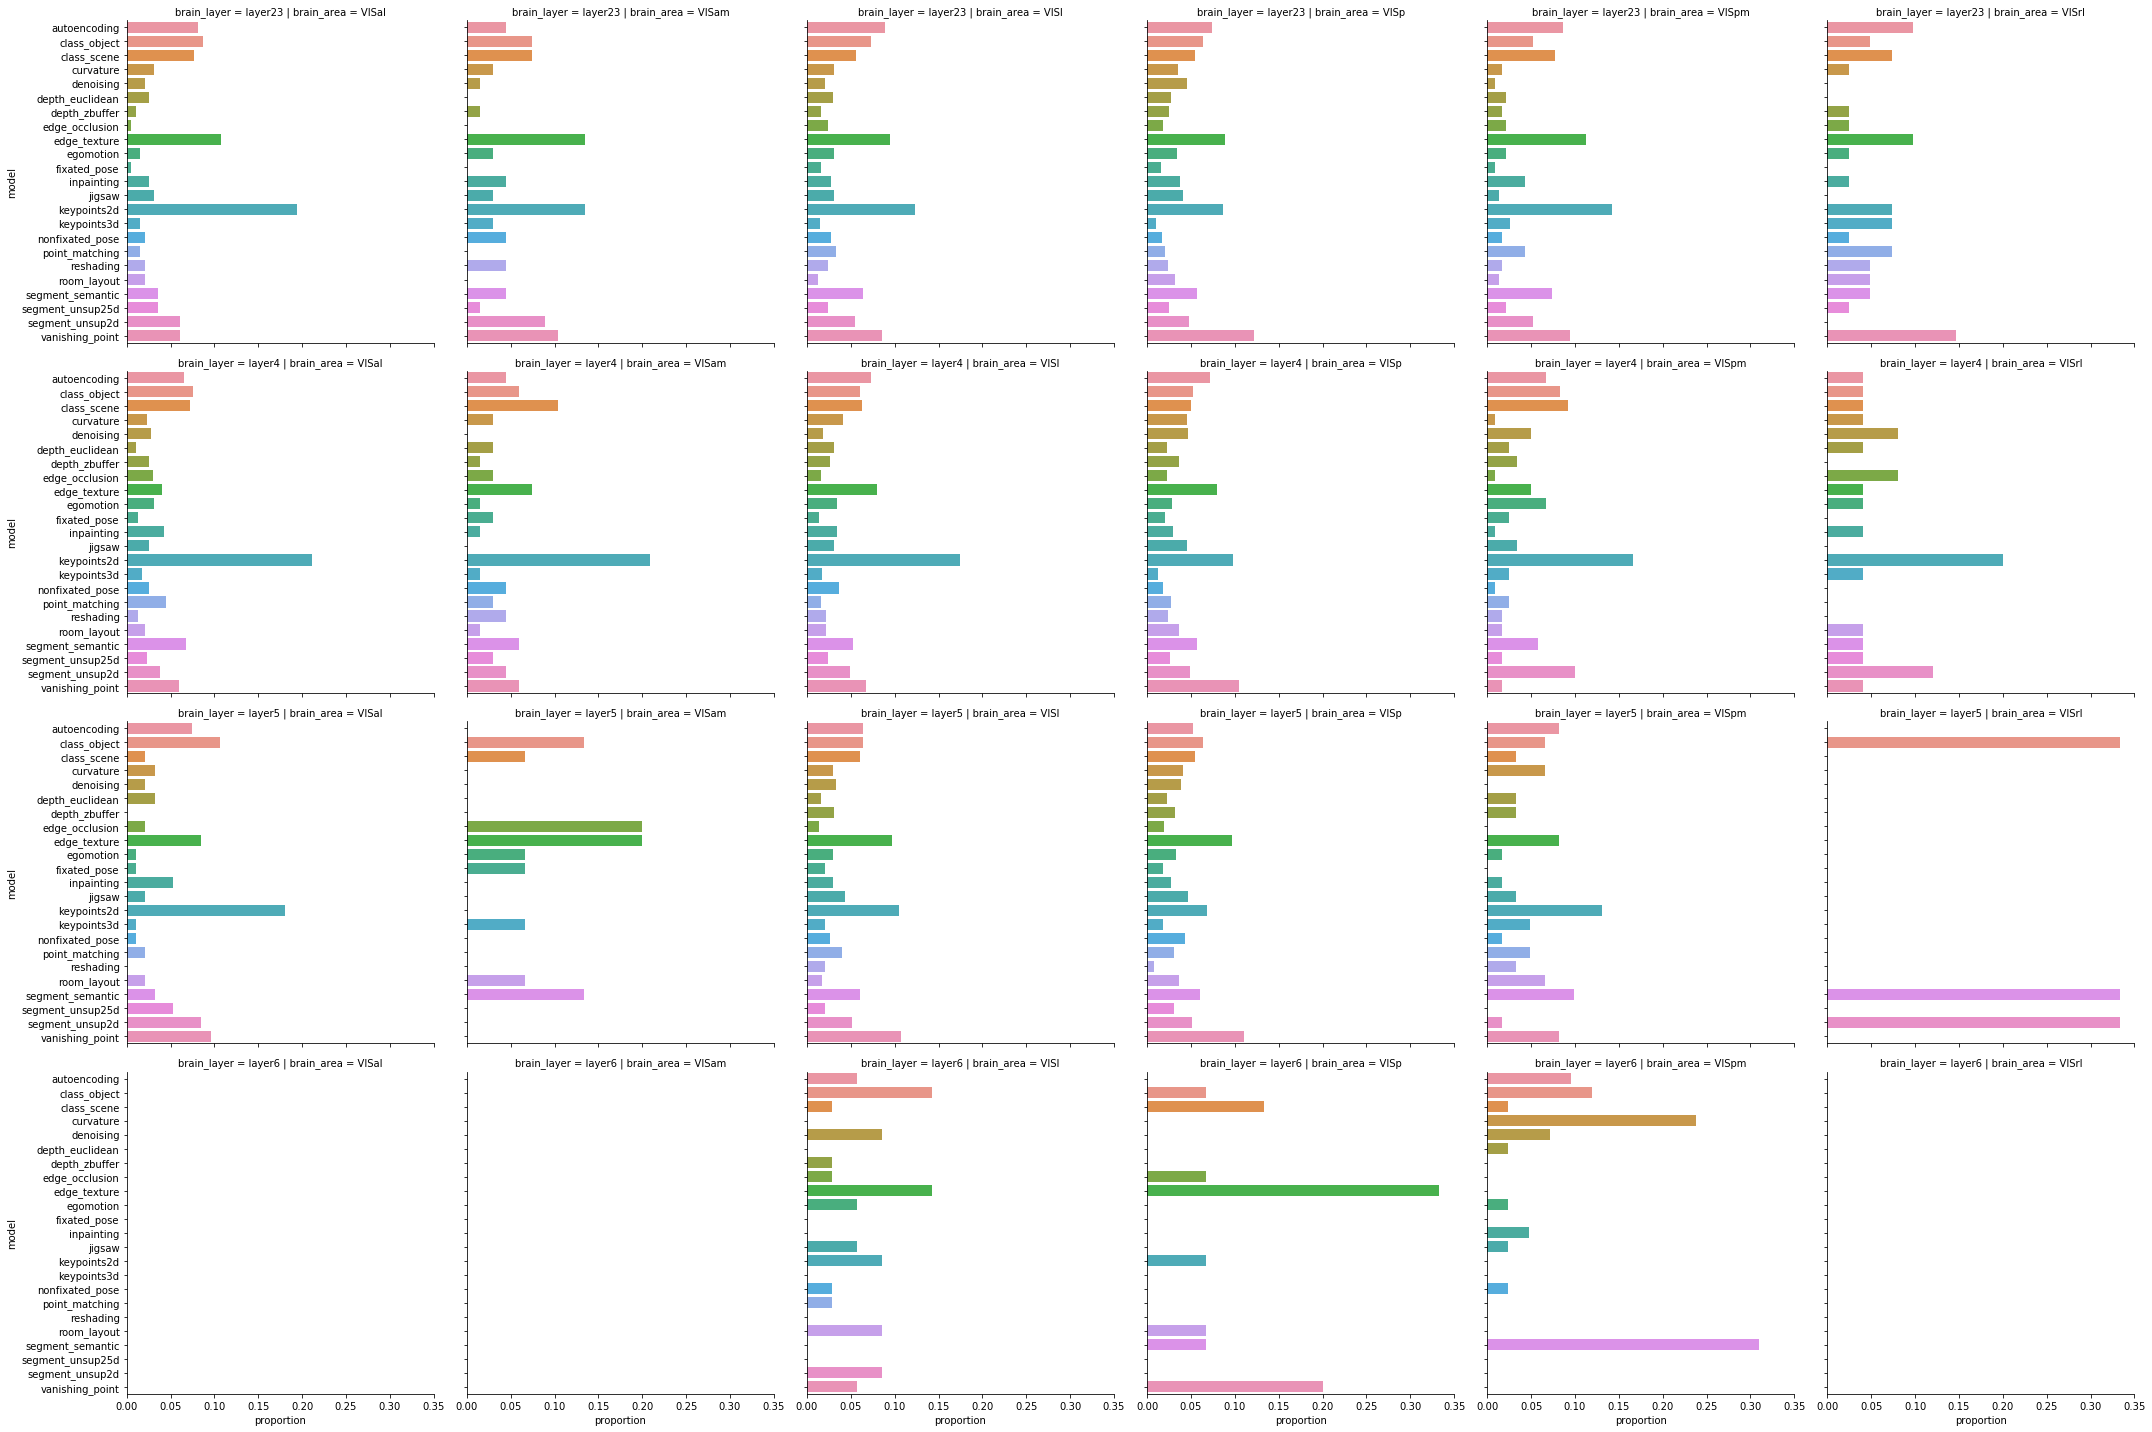

In [350]:
sns.catplot(x='proportion', y='model', kind='bar', col = 'brain_area', row = 'brain_layer', data=top_task_status_bysite);

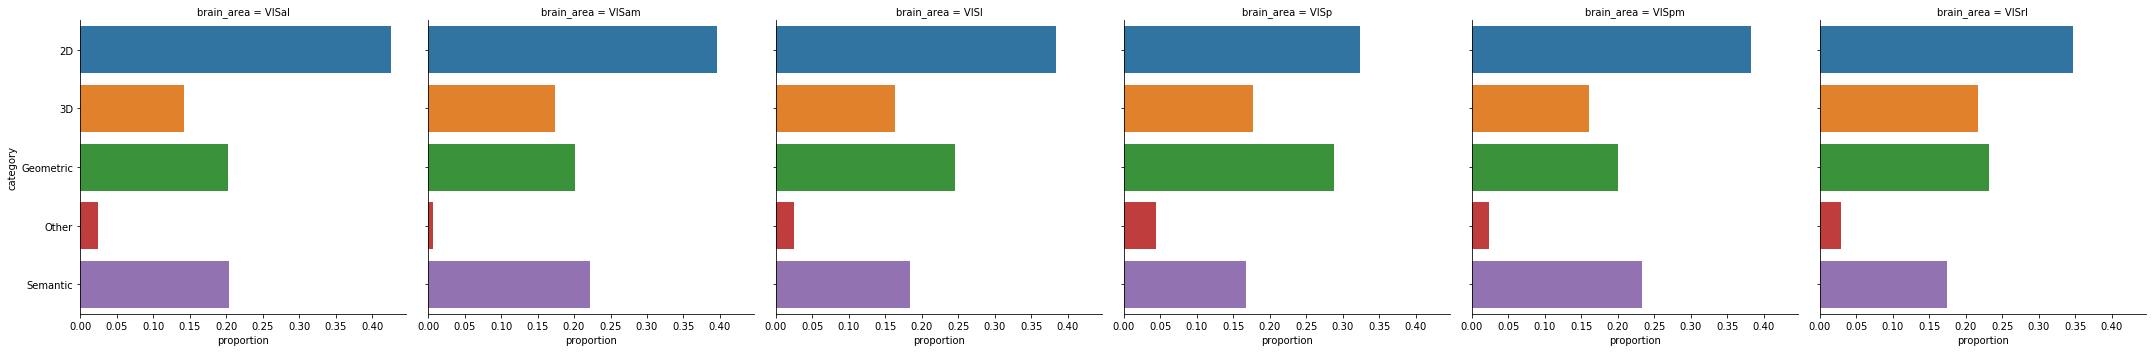

In [351]:
sns.catplot(x='proportion', y='category', kind='bar', col = 'brain_area', 
            data=top_task_status_byarea.groupby(['brain_area','category'])['proportion'].sum().reset_index());

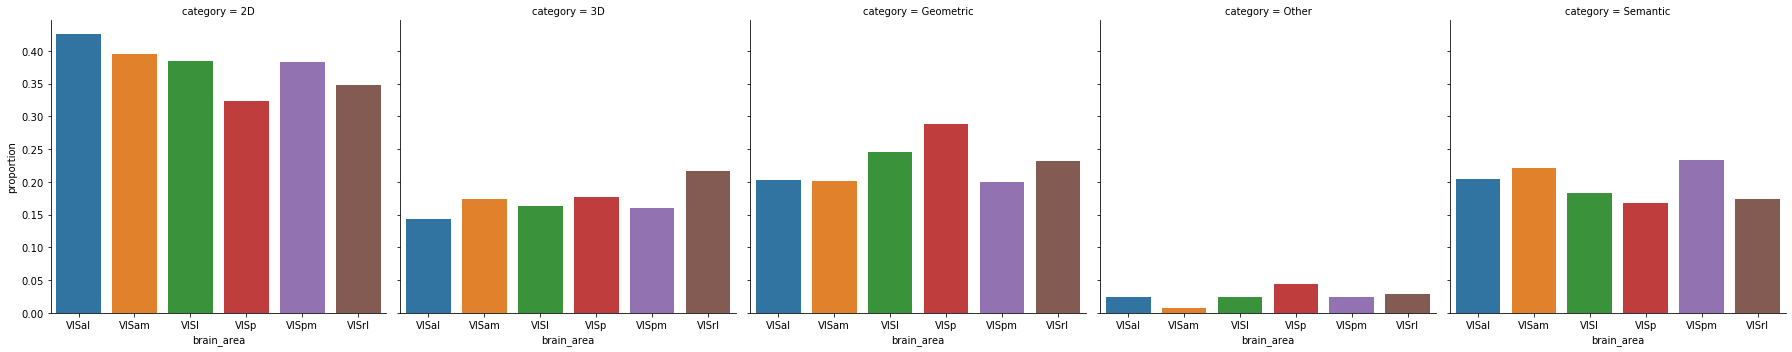

In [352]:
sns.catplot(x='brain_area', y='proportion', kind='bar', col = 'category', 
            data=top_task_status_byarea.groupby(['brain_area','category'])['proportion'].sum().reset_index());

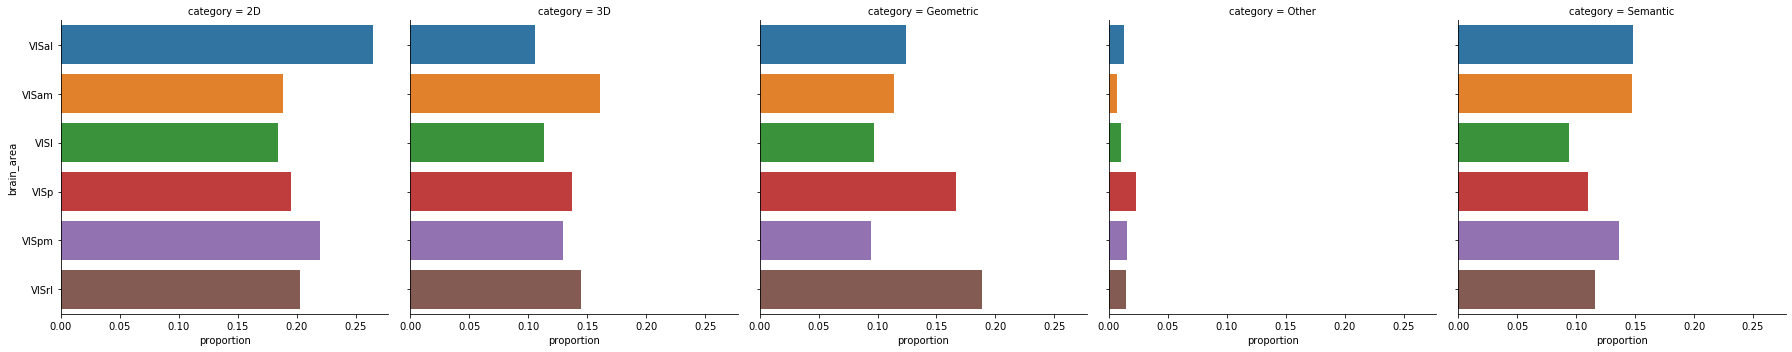

In [284]:
sns.catplot(x='proportion', y='brain_area', kind='bar', col = 'category', 
            data=top_task_status_byarea.groupby(['brain_area','category'])['proportion'].sum().reset_index());

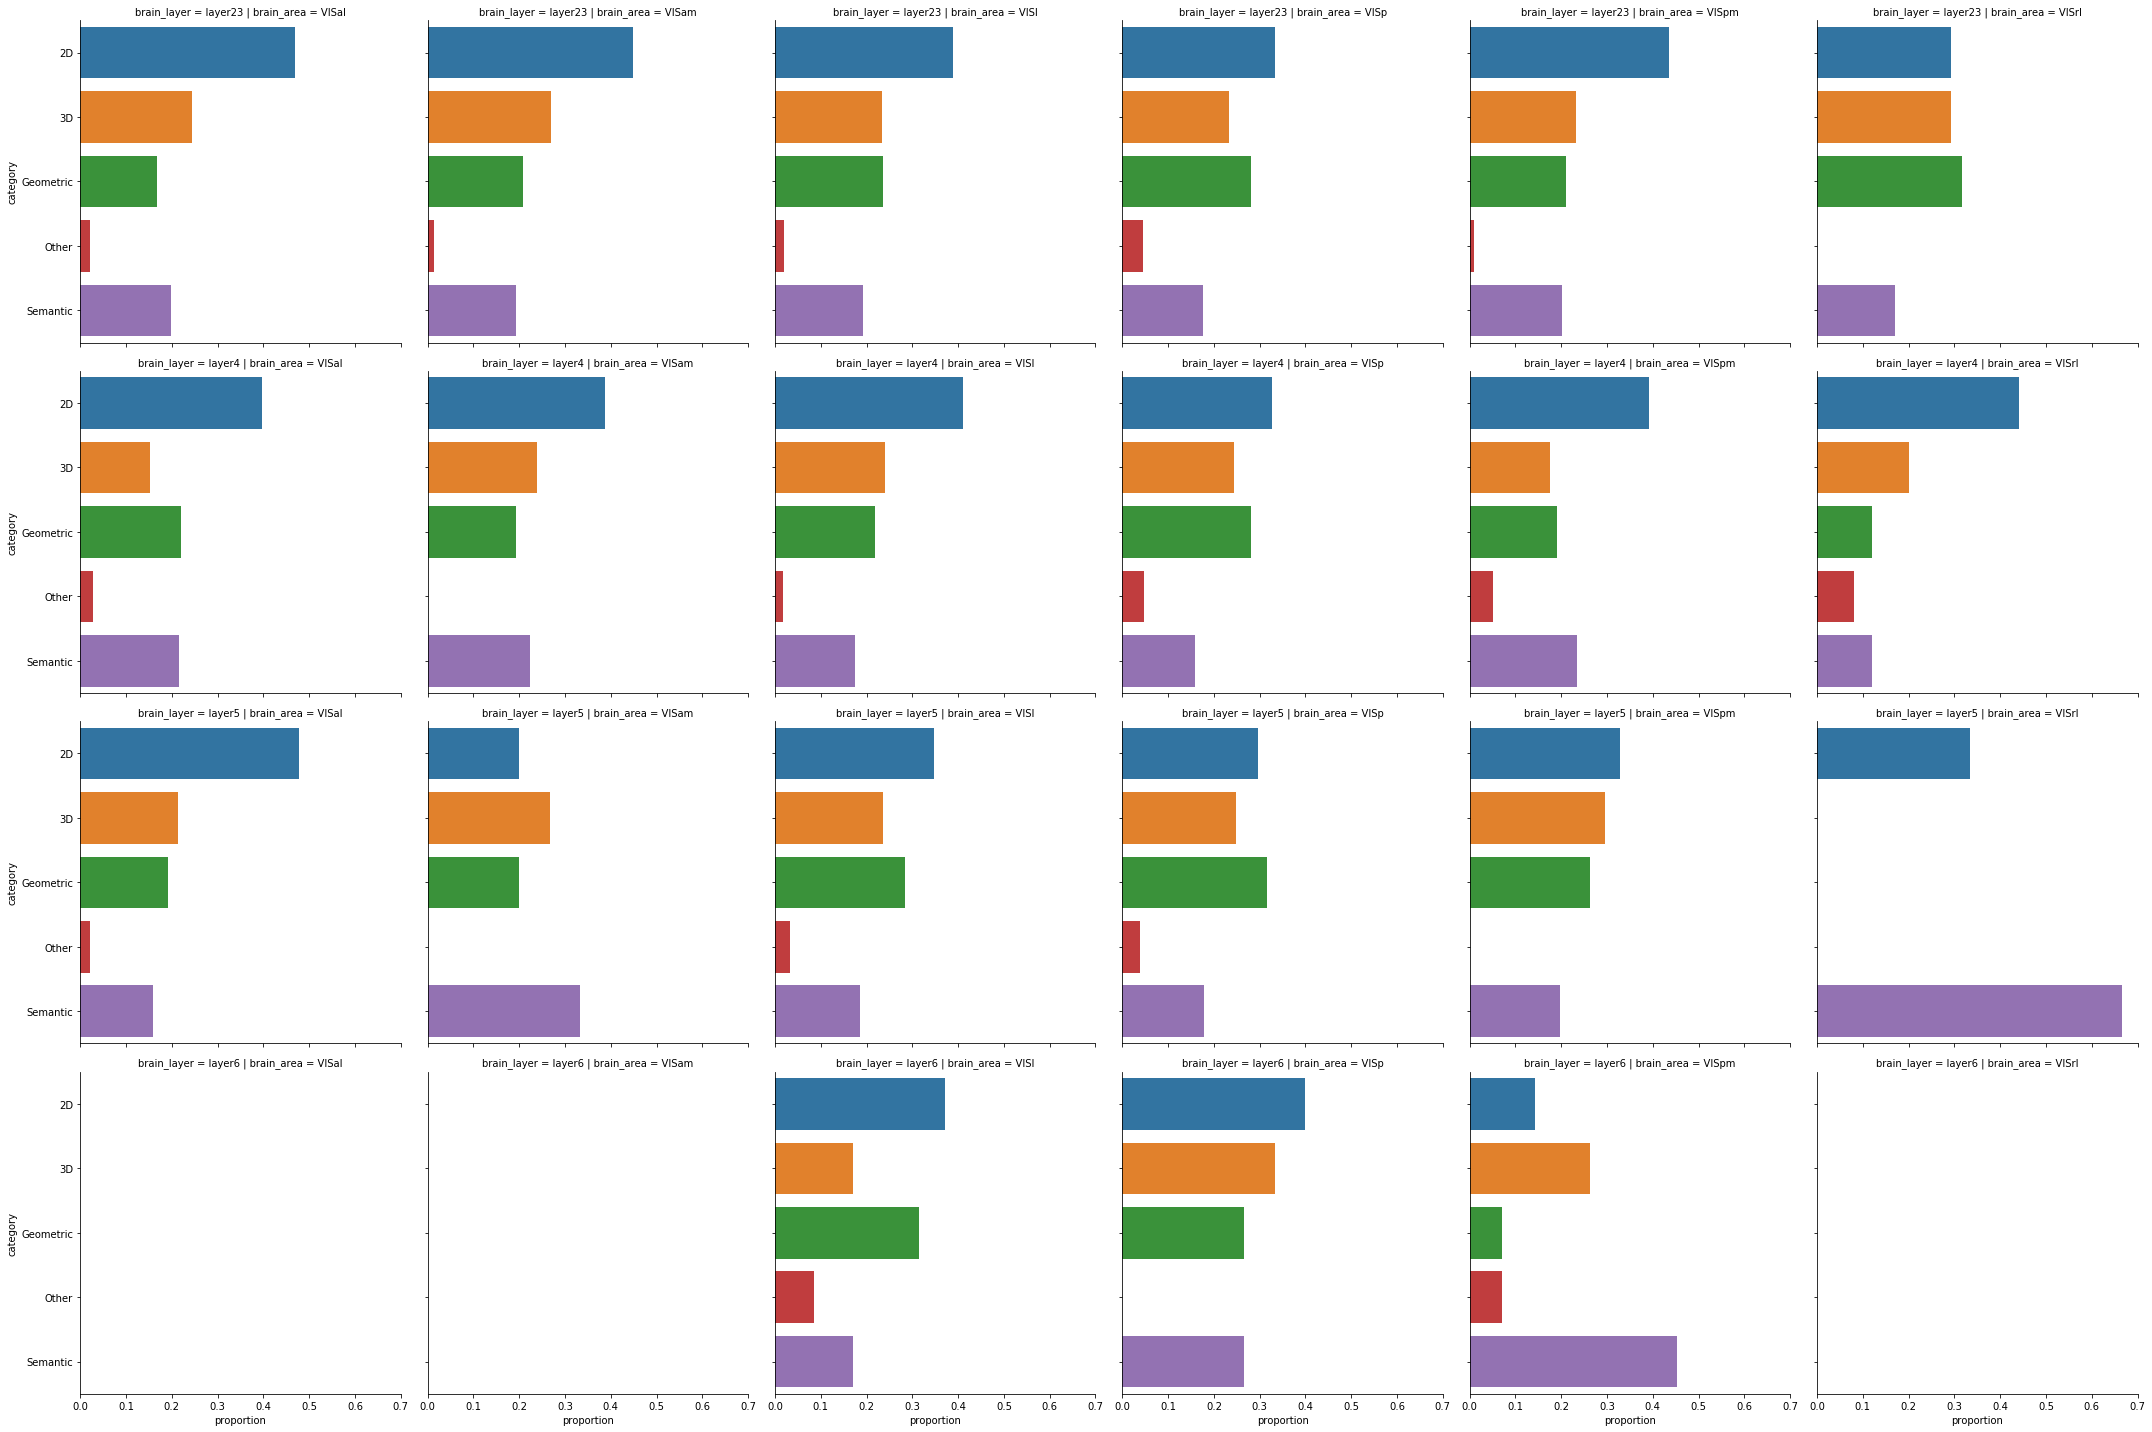

In [260]:
sns.catplot(x='proportion', y='category', kind='bar', col = 'brain_area', row = 'brain_layer', 
            data=top_task_status_bysite.groupby(['brain_area','brain_layer','category'])['proportion'].sum().reset_index());

### Model Hierarchy by Max Scores in Each Neuron

In [25]:
max_scores = (scoresheet[scoresheet.groupby(['brain_area', 'brain_layer','neuron','model','training'])['score']
                         .transform(max) == scoresheet['score']]).reset_index(drop=True)
max_scores = max_scores[~max_scores.duplicated(['brain_area', 'brain_layer','neuron','model','training','score'])]
max_scores['model_layer_number'] = max_scores['model_layer'].apply(lambda x: int(x.split('-')[1]))
max_scores = max_scores[max_scores['training'].isin(['taskonomy','imagenet','random'])]

In [26]:
max_scores.groupby('training')['model_layer_number'].median()

training
imagenet     11
random        5
taskonomy    16
Name: model_layer_number, dtype: int64

In [27]:
max_scores[max_scores['score'] == max(max_scores['score'])]

,brain_area,brain_layer,neuron,model,training,model_layer,score,cell_specimen_id,model_string,neural_site,model_layer_string,model_layer_number
259405,VISpm,layer5,95,segment_semantic,taskonomy,BatchNorm2d-31,0.733872,610466917,segment_semantic_taskonomy,VISpm_layer5,segment_semantic_BatchNorm2d-31,31


In [91]:
max_scores_bysite = max_scores.groupby(['brain_area','brain_layer', 'model','training'])['score'].mean().reset_index()

In [92]:
max_scores_bysite.sort_values(by='score', ascending = 0).head(20)

,brain_area,brain_layer,model,training,score
764,VISpm,layer6,segment_semantic,taskonomy,0.468956
753,VISpm,layer6,mobilenet_v2,random,0.460501
736,VISpm,layer6,curvature,taskonomy,0.454471
739,VISpm,layer6,densenet161,random,0.450594
748,VISpm,layer6,keypoints2d,taskonomy,0.445741
733,VISpm,layer6,autoencoding,taskonomy,0.445061
768,VISpm,layer6,squeezenet1_0,random,0.442777
737,VISpm,layer6,denoising,taskonomy,0.441486
744,VISpm,layer6,egomotion,taskonomy,0.440449
771,VISpm,layer6,vgg16,random,0.439780


In [93]:
(max_scores_bysite[(max_scores_bysite['brain_area'] != 'VISpm') & (max_scores_bysite['brain_layer'] != 'layer6')]
 .sort_values(by='score', ascending = 0).head(20))

,brain_area,brain_layer,model,training,score
867,VISrl,layer5,densenet161,imagenet,0.260721
241,VISam,layer5,resnet152,imagenet,0.253996
781,VISrl,layer23,densenet161,imagenet,0.250862
136,VISam,layer23,densenet161,imagenet,0.250021
222,VISam,layer5,densenet161,imagenet,0.249258
179,VISam,layer4,densenet161,imagenet,0.244125
800,VISrl,layer23,resnet152,imagenet,0.243651
155,VISam,layer23,resnet152,imagenet,0.242999
895,VISrl,layer5,segment_unsup2d,taskonomy,0.242122
893,VISrl,layer5,segment_semantic,taskonomy,0.241647


In [95]:
(max_scores_bysite[(max_scores_bysite['brain_area'] == 'VISp') & (max_scores_bysite['brain_layer'] == 'layer4')]
 .sort_values(by='score', ascending = 0).head(20))

,brain_area,brain_layer,model,training,score
480,VISp,layer4,densenet161,imagenet,0.205064
499,VISp,layer4,resnet152,imagenet,0.199544
503,VISp,layer4,resnet50,imagenet,0.178531
492,VISp,layer4,mnasnet1_0,imagenet,0.173716
494,VISp,layer4,mobilenet_v2,imagenet,0.170088
476,VISp,layer4,class_object,taskonomy,0.167867
511,VISp,layer4,vanishing_point,taskonomy,0.167866
506,VISp,layer4,segment_semantic,taskonomy,0.166827
477,VISp,layer4,class_scene,taskonomy,0.164662
485,VISp,layer4,edge_texture,taskonomy,0.164536


In [28]:
max_scores.anova(dv='score', between=['model'])

,Source,ddof1,ddof2,F,p-unc,np2
0,model,32,284240,195.038451,0.0,0.021486


In [29]:
max_scores.anova(dv='score', between=['neural_site'])

,Source,ddof1,ddof2,F,p-unc,np2
0,neural_site,20,284252,1747.942117,0.0,0.109516


In [30]:
max_scores.anova(dv='score', between=['model','neural_site'])

,Source,SS,DF,MS,F,p-unc,np2
0,model,32.276239,32.0,1.008632,219.648430,0.000000,0.024186
1,neural_site,164.516774,20.0,8.225839,1791.328979,0.000000,0.112166
2,model * neural_site,3.209200,640.0,0.005014,1.091973,0.053275,0.002458
3,Residual,1302.208226,283580.0,0.004592,NaN,NaN,NaN


#### Object Models

In [31]:
model_metadata = pd.read_csv('model_opts/model_metadata.csv')
model_metadata['model'] = model_metadata['model_name']

In [32]:
max_scores_imagenet = max_scores[max_scores['training'].isin(['imagenet','random'])].merge(model_metadata, on='model')

In [33]:
stats.pearsonr(max_scores_imagenet[max_scores_imagenet['training'] == 'imagenet']['parameter_count'], 
               max_scores_imagenet[max_scores_imagenet['training'] == 'imagenet']['score'])

(-0.12202459202825189, 1.119705570628948e-217)

In [34]:
stats.pearsonr(max_scores_imagenet[max_scores_imagenet['training'] == 'imagenet']['layer_count'], 
               max_scores_imagenet[max_scores_imagenet['training'] == 'imagenet']['score'])

(0.28696263194706245, 0.0)

In [35]:
stats.pearsonr(max_scores_imagenet[max_scores_imagenet['training'] == 'imagenet']['total_feature_count'], 
               max_scores_imagenet[max_scores_imagenet['training'] == 'imagenet']['score'])

(0.23063565974357986, 0.0)

In [36]:
max_scores_imagenet.query("training == 'imagenet'")['score'].mean()

0.18224250845253268

In [37]:
max_scores_imagenet.query("training == 'random'")['score'].mean()

0.14359193882310428

In [38]:
pg.ttest(max_scores.query("training == 'imagenet'").sort_values(by=['brain_area','brain_layer','neuron','model'])['score'], 
         max_scores.query("training == 'random'").sort_values(by=['brain_area','brain_layer','neuron','model'])['score'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,152.340679,66109,two-sided,0.0,"[0.04, 0.04]",0.549686,inf,1.0


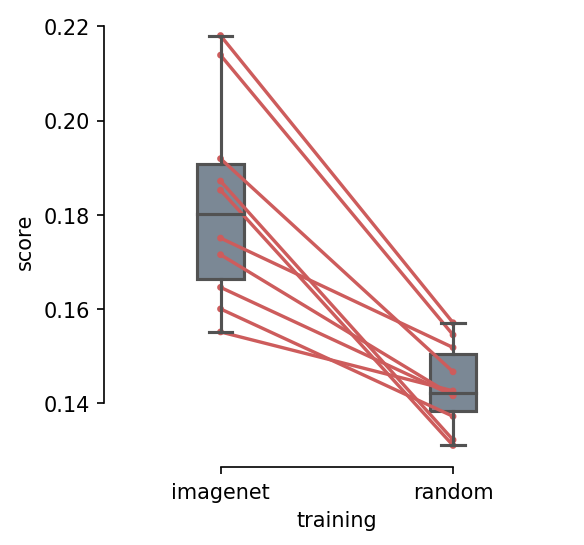

In [42]:
pg.plot_paired(data=max_scores_imagenet.groupby(['model','training'])['score'].mean().reset_index(), dv='score', 
                                                within='training', subject='model', dpi=150);

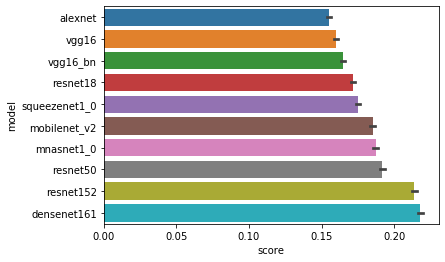

In [39]:
sns.barplot(x='score', y='model', data=max_scores_imagenet.query("training == 'imagenet'"),
            order=(max_scores_imagenet.query("training == 'imagenet'").groupby(['model'])['score']
                                              .mean().reset_index().sort_values(by='score')['model']));

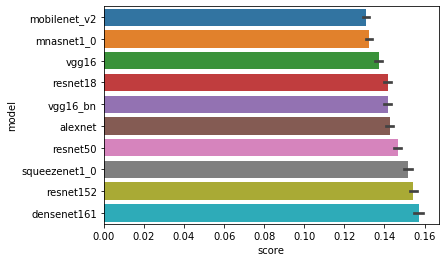

In [40]:
sns.barplot(x='score', y='model', data=max_scores_imagenet.query("training == 'random'"),
            order=(max_scores_imagenet.query("training == 'random'").groupby(['model'])['score']
                                              .mean().reset_index().sort_values(by='score')['model']));

In [41]:
max_scores_imagenet.groupby(['model','training'])['score'].mean().reset_index()

,model,training,score
0,alexnet,imagenet,0.155095
1,alexnet,random,0.142568
2,densenet161,imagenet,0.218066
3,densenet161,random,0.157047
4,mnasnet1_0,imagenet,0.187152
5,mnasnet1_0,random,0.132159
6,mobilenet_v2,imagenet,0.185212
7,mobilenet_v2,random,0.130968
8,resnet152,imagenet,0.213908
9,resnet152,random,0.154464


#### Taskonomy Models

In [49]:
max_scores_taskonomy = max_scores.query("training == 'taskonomy'")

In [62]:
max_scores_taskonomy.anova(dv='score', between=['neural_site','model'])

,Source,SS,DF,MS,F,p-unc,np2
0,neural_site,90.992402,20.0,4.549620,991.322349,0.000000,0.115676
1,model,7.814785,22.0,0.355217,77.398779,0.000000,0.011109
2,neural_site * model,2.405442,440.0,0.005467,1.191192,0.003566,0.003446
3,Residual,695.622285,151570.0,0.004589,NaN,NaN,NaN


In [63]:
max_scores_taskonomy.anova(dv='score', between=['brain_area','model'])

,Source,SS,DF,MS,F,p-unc,np2
0,brain_area,35.155124,5.0,7.031025,1419.290977,0.000000e+00,0.044629
1,model,7.814785,22.0,0.355217,71.704624,3.861815e-319,0.010277
2,brain_area * model,1.293377,110.0,0.011758,2.373478,2.745447e-14,0.001716
3,Residual,752.571628,151915.0,0.004954,NaN,NaN,NaN


In [64]:
task_pairwise_bysite = pg.pairwise_ttests(data=max_scores_taskonomy, dv='score', between = ['neural_site', 'model'], 
                                   parametric=False, padjust='bonf', effsize='hedges').round(5)

In [65]:
task_pairwise_byarea = pg.pairwise_ttests(data=max_scores_taskonomy, dv='score', between = ['brain_area', 'model'], 
                                   parametric=False, padjust='bonf', effsize='hedges').round(5)

In [66]:
task_pairwise_bysite_signif = task_pairwise_bysite[(task_pairwise_bysite['Contrast'] == 'neural_site * model') &
                                                   (task_pairwise_bysite['p-corr'] < 0.05)]

In [70]:
task_pairwise_byarea_signif = task_pairwise_byarea[(task_pairwise_byarea['Contrast'] == 'brain_area * model') & 
                                     (task_pairwise_byarea['p-corr'] < 0.05)]

In [361]:
task_pairwise_bysite[(task_pairwise_bysite['Contrast'] == 'neural_site * model')]

,Contrast,neural_site,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
463,neural_site * model,VISam_layer5,autoencoding,class_scene,False,False,77.0,two-sided,0.14658,1.0,bonf,-0.55812
464,neural_site * model,VISam_layer5,autoencoding,point_matching,False,False,99.0,two-sided,0.58974,1.0,bonf,-0.15644
465,neural_site * model,VISam_layer5,autoencoding,fixated_pose,False,False,95.0,two-sided,0.48073,1.0,bonf,-0.32468
466,neural_site * model,VISam_layer5,autoencoding,nonfixated_pose,False,False,103.0,two-sided,0.70892,1.0,bonf,-0.19512
467,neural_site * model,VISam_layer5,autoencoding,keypoints3d,False,False,86.0,two-sided,0.28084,1.0,bonf,-0.40329
...,...,...,...,...,...,...,...,...,...,...,...,...
5771,neural_site * model,VISam_layer4,inpainting,room_layout,False,False,2114.0,two-sided,0.56294,1.0,bonf,-0.08208
5772,neural_site * model,VISam_layer4,inpainting,segment_semantic,False,False,1969.0,two-sided,0.22106,1.0,bonf,-0.22346
5773,neural_site * model,VISam_layer4,denoising,room_layout,False,False,1875.0,two-sided,0.10059,1.0,bonf,-0.31574
5774,neural_site * model,VISam_layer4,denoising,segment_semantic,False,False,1733.0,two-sided,0.02297,1.0,bonf,-0.45747


In [68]:
task_pairwise_bysite_signif.sort_values(by='hedges')

,Contrast,neural_site,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
2813,neural_site * model,VISal_layer23,fixated_pose,class_object,False,False,13965.0,two-sided,0.00000,0.01570,bonf,-0.47610
2893,neural_site * model,VISal_layer23,edge_occlusion,class_object,False,False,14051.0,two-sided,0.00000,0.02275,bonf,-0.47519
967,neural_site * model,VISl_layer5,denoising,segment_semantic,False,False,121884.0,two-sided,0.00000,0.00000,bonf,-0.44940
4198,neural_site * model,VISal_layer4,jigsaw,keypoints2d,False,False,85890.0,two-sided,0.00000,0.00000,bonf,-0.44615
4082,neural_site * model,VISal_layer4,fixated_pose,keypoints2d,False,False,83603.0,two-sided,0.00000,0.00000,bonf,-0.43693
...,...,...,...,...,...,...,...,...,...,...,...,...
2709,neural_site * model,VISl_layer23,class_object,denoising,False,False,190174.0,two-sided,0.00000,0.00000,bonf,0.44575
2962,neural_site * model,VISal_layer23,class_object,denoising,False,False,24293.0,two-sided,0.00001,0.03089,bonf,0.46449
921,neural_site * model,VISl_layer5,vanishing_point,denoising,False,False,218728.0,two-sided,0.00000,0.00000,bonf,0.46664
938,neural_site * model,VISl_layer5,class_object,denoising,False,False,216753.0,two-sided,0.00000,0.00000,bonf,0.49018


In [357]:
task_pairwise_byarea[(task_pairwise_byarea['Contrast'] == 'brain_area * model')]

,Contrast,brain_area,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
268,brain_area * model,VISam,autoencoding,class_scene,False,False,8945.0,two-sided,0.00376,1.00000,bonf,-0.32843
269,brain_area * model,VISam,autoencoding,point_matching,False,False,10931.0,two-sided,0.82025,1.00000,bonf,-0.03171
270,brain_area * model,VISam,autoencoding,fixated_pose,False,False,11478.0,two-sided,0.61223,1.00000,bonf,0.04452
271,brain_area * model,VISam,autoencoding,nonfixated_pose,False,False,11688.0,two-sided,0.42997,1.00000,bonf,0.01296
272,brain_area * model,VISam,autoencoding,keypoints3d,False,False,10979.0,two-sided,0.87076,1.00000,bonf,-0.03382
...,...,...,...,...,...,...,...,...,...,...,...,...
1781,brain_area * model,VISal,inpainting,room_layout,False,False,300798.0,two-sided,0.29939,1.00000,bonf,0.06203
1782,brain_area * model,VISal,inpainting,segment_semantic,False,False,259871.0,two-sided,0.00021,0.31728,bonf,-0.14838
1783,brain_area * model,VISal,denoising,room_layout,False,False,283764.0,two-sided,0.34859,1.00000,bonf,-0.05492
1784,brain_area * model,VISal,denoising,segment_semantic,False,False,240502.0,two-sided,0.00000,0.00000,bonf,-0.27280


In [71]:
task_pairwise_byarea_signif.sort_values(by='hedges')

,Contrast,brain_area,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
519,brain_area * model,VISam,denoising,segment_semantic,False,False,7968.0,two-sided,0.00003,0.03859,bonf,-0.48542
1690,brain_area * model,VISal,edge_occlusion,keypoints2d,False,False,224727.0,two-sided,0.00000,0.00000,bonf,-0.43797
1726,brain_area * model,VISal,jigsaw,keypoints2d,False,False,230952.0,two-sided,0.00000,0.00000,bonf,-0.43536
1610,brain_area * model,VISal,fixated_pose,keypoints2d,False,False,225373.0,two-sided,0.00000,0.00000,bonf,-0.43136
1686,brain_area * model,VISal,edge_occlusion,class_object,False,False,213217.0,two-sided,0.00000,0.00000,bonf,-0.42493
...,...,...,...,...,...,...,...,...,...,...,...,...
743,brain_area * model,VISl,class_object,denoising,False,False,2304334.0,two-sided,0.00000,0.00000,bonf,0.40867
979,brain_area * model,VISp,vanishing_point,denoising,False,False,6826878.0,two-sided,0.00000,0.00000,bonf,0.43453
508,brain_area * model,VISam,edge_texture,denoising,False,False,14620.0,two-sided,0.00000,0.00339,bonf,0.48746
308,brain_area * model,VISam,class_scene,denoising,False,False,14638.0,two-sided,0.00000,0.00300,bonf,0.55080


In [75]:
np.mean(np.abs(task_pairwise_bysite_signif['hedges']))

0.27182118609406963

In [69]:
for row_i_i, row_i in task_pairwise_bysite_signif.iterrows():
    for row_j_i, row_j in task_pairwise_bysite_signif.iterrows():
        if (row_i['A'] == row_j['A']) and (row_i['B'] == row_j['B']) and ((row_i['hedges'] < 0) != (row_j['hedges'] < 0)):
            print(row_i, row_j)

In [72]:
for row_i_i, row_i in task_pairwise_byarea_signif.iterrows():
    for row_j_i, row_j in task_pairwise_byarea_signif.iterrows():
        if (row_i['A'] == row_j['A']) and (row_i['B'] == row_j['B']) and ((row_i['hedges'] < 0) != (row_j['hedges'] < 0)):
            print(row_i, row_j)

In [73]:
taskonomy_nnls = pd.read_csv('taskonomy_2020/taskonomy_results/taskonomy_nnls_bylayer.csv')

In [ ]:
nnls_reg_combo = (max_scores_taskonomy.groupby(['model'])['score'].mean().reset_index()
                  .merge(taskonomy_nnls.groupby(['model'])['nnls_r'].mean().reset_index(), on='model'))

In [ ]:
stats.pearsonr(nnls_reg_combo.score, nnls_reg_combo.nnls_r)

In [ ]:
nnls_reg_combo

In [ ]:
max_scores_taskonomy

In [ ]:
sns.barplot(x='score', y='model', data=max_scores_taskonomy,
           order=max_scores_taskonomy.groupby(['model'])['score'].mean().reset_index().sort_values(by='score')['model']);

In [ ]:
sns.catplot(x='score', y='model_string', kind='bar', col = 'brain_area', data=max_scores.query("training != 'taskonomy'"));

In [ ]:
sns.catplot(x='score', y='model_string', kind='bar', #palette=sns.light_palette('navy'), 
            col = 'brain_area', row = 'brain_layer', data=max_scores.query("training != 'taskonomy'"));

In [61]:
max_scores.to_csv('srp_ridge_max_scores.csv', index = None)

#### Taskonomy Clusters

In [50]:
task_definitions = pd.read_csv('taskonomy_2020/task_definitions.csv')

In [51]:
max_scores_task_plus = max_scores_taskonomy[['brain_area', 'brain_layer', 'neural_site', 'cell_specimen_id', 'model','model_layer', 'score']]
max_scores_task_plus = max_scores_task_plus.merge(task_definitions, on='model')

In [53]:
max_scores_task_plus.anova(dv='score', between=['neural_site','category'])

,Source,SS,DF,MS,F,p-unc,np2
0,neural_site,91.029041,20.0,4.551452,994.653173,0.000000e+00,0.115764
1,category,4.773411,4.0,1.193353,260.789770,9.334351e-224,0.006818
2,neural_site * category,0.986024,80.0,0.012325,2.693514,2.330331e-14,0.001416
3,Residual,695.301692,151948.0,0.004576,NaN,NaN,NaN


In [55]:
max_scores_task_plus.anova(dv='score', between=['brain_area','category'])

,Source,SS,DF,MS,F,p-unc,np2
0,brain_area,35.538088,5.0,7.107618,1438.558700,0.000000e+00,0.045176
1,category,4.773411,4.0,1.193353,241.530724,3.589592e-207,0.006315
2,brain_area * category,0.664828,20.0,0.033241,6.727953,5.533959e-19,0.000884
3,Residual,751.113840,152023.0,0.004941,NaN,NaN,NaN


In [59]:
task_category_pairwise_bysite = pg.pairwise_ttests(data=max_scores_task_plus, dv='score', between = ['neural_site', 'model'], 
                                                   parametric=False, padjust='bonf', effsize='hedges').round(5)

In [281]:
task_category_pairwise_bysite_signif = task_category_pairwise_bysite[(task_category_pairwise_bysite['Contrast'] == 'neural_site * model') &
                                                   (task_category_pairwise_bysite['p-corr'] < 0.05)]

In [365]:
task_category_pairwise_bysite[(task_category_pairwise_bysite['Contrast'] == 'neural_site * model')]

,Contrast,neural_site,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
441,neural_site * model,VISam_layer5,autoencoding,class_scene,False,False,77.0,two-sided,0.14658,1.0,bonf,-0.55812
442,neural_site * model,VISam_layer5,autoencoding,point_matching,False,False,99.0,two-sided,0.58974,1.0,bonf,-0.15644
443,neural_site * model,VISam_layer5,autoencoding,fixated_pose,False,False,95.0,two-sided,0.48073,1.0,bonf,-0.32468
444,neural_site * model,VISam_layer5,autoencoding,nonfixated_pose,False,False,103.0,two-sided,0.70892,1.0,bonf,-0.19512
445,neural_site * model,VISam_layer5,autoencoding,keypoints3d,False,False,86.0,two-sided,0.28084,1.0,bonf,-0.40329
...,...,...,...,...,...,...,...,...,...,...,...,...
5287,neural_site * model,VISam_layer4,inpainting,room_layout,False,False,2114.0,two-sided,0.56294,1.0,bonf,-0.08208
5288,neural_site * model,VISam_layer4,inpainting,segment_semantic,False,False,1969.0,two-sided,0.22106,1.0,bonf,-0.22346
5289,neural_site * model,VISam_layer4,denoising,room_layout,False,False,1875.0,two-sided,0.10059,1.0,bonf,-0.31574
5290,neural_site * model,VISam_layer4,denoising,segment_semantic,False,False,1733.0,two-sided,0.02297,1.0,bonf,-0.45747


In [366]:
task_category_pairwise_bysite_signif

,Contrast,neural_site,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
682,neural_site * model,VISl_layer5,autoencoding,vanishing_point,False,False,136919.0,two-sided,0.0,0.00033,bonf,-0.26958
684,neural_site * model,VISl_layer5,autoencoding,class_object,False,False,137545.0,two-sided,0.0,0.00061,bonf,-0.30770
687,neural_site * model,VISl_layer5,autoencoding,edge_texture,False,False,282594.0,two-sided,0.0,0.00044,bonf,-0.24985
692,neural_site * model,VISl_layer5,autoencoding,segment_semantic,False,False,140950.0,two-sided,0.0,0.01345,bonf,-0.26243
694,neural_site * model,VISl_layer5,class_scene,fixated_pose,False,False,199845.0,two-sided,0.0,0.00007,bonf,0.32665
...,...,...,...,...,...,...,...,...,...,...,...,...
4818,neural_site * model,VISl_layer4,edge_texture,room_layout,False,False,651618.0,two-sided,0.0,0.00025,bonf,0.15992
4821,neural_site * model,VISl_layer4,keypoints2d,denoising,False,False,330488.0,two-sided,0.0,0.00067,bonf,0.30852
4826,neural_site * model,VISl_layer4,inpainting,segment_semantic,False,False,241588.0,two-sided,0.0,0.00094,bonf,-0.20896
4828,neural_site * model,VISl_layer4,denoising,segment_semantic,False,False,232554.0,two-sided,0.0,0.00000,bonf,-0.29260


In [283]:
for row_i_i, row_i in task_category_pairwise_bysite_signif.iterrows():
    for row_j_i, row_j in task_category_pairwise_bysite_signif.iterrows():
        if (row_i['A'] == row_j['A']) and (row_i['B'] == row_j['B']) and ((row_i['hedges'] < 0) != (row_j['hedges'] < 0)):
            print(row_i, row_j)

In [60]:
task_category_pairwise_byarea = pg.pairwise_ttests(data=max_scores_task_plus, dv='score', between = ['brain_area', 'model'], 
                                                   parametric=False, padjust='bonf', effsize='hedges').round(5)

In [372]:
task_category_pairwise_byarea_signif = task_category_pairwise_byarea[(task_category_pairwise_byarea['Contrast'] == 'brain_area * model') &
                                                   (task_category_pairwise_byarea['p-corr'] < 0.05)]

In [371]:
task_category_pairwise_byarea[(task_category_pairwise_byarea['Contrast'] == 'brain_area * model')]

,Contrast,brain_area,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
246,brain_area * model,VISam,autoencoding,class_scene,False,False,8945.0,two-sided,0.00376,1.00000,bonf,-0.32843
247,brain_area * model,VISam,autoencoding,point_matching,False,False,10931.0,two-sided,0.82025,1.00000,bonf,-0.03171
248,brain_area * model,VISam,autoencoding,fixated_pose,False,False,11478.0,two-sided,0.61223,1.00000,bonf,0.04452
249,brain_area * model,VISam,autoencoding,nonfixated_pose,False,False,11688.0,two-sided,0.42997,1.00000,bonf,0.01296
250,brain_area * model,VISam,autoencoding,keypoints3d,False,False,10979.0,two-sided,0.87076,1.00000,bonf,-0.03382
...,...,...,...,...,...,...,...,...,...,...,...,...
1627,brain_area * model,VISal,inpainting,room_layout,False,False,300798.0,two-sided,0.29939,1.00000,bonf,0.06203
1628,brain_area * model,VISal,inpainting,segment_semantic,False,False,259871.0,two-sided,0.00021,0.28969,bonf,-0.14838
1629,brain_area * model,VISal,denoising,room_layout,False,False,283764.0,two-sided,0.34859,1.00000,bonf,-0.05492
1630,brain_area * model,VISal,denoising,segment_semantic,False,False,240502.0,two-sided,0.00000,0.00000,bonf,-0.27280


In [373]:
task_category_pairwise_byarea_signif

,Contrast,brain_area,A,B,Paired,Parametric,U-val,Tail,p-unc,p-corr,p-adjust,hedges
284,brain_area * model,VISam,class_scene,denoising,False,False,14638.0,two-sided,0.00000,0.00274,bonf,0.55080
446,brain_area * model,VISam,class_object,denoising,False,False,14825.0,two-sided,0.00000,0.00077,bonf,0.57302
464,brain_area * model,VISam,edge_texture,denoising,False,False,29240.0,two-sided,0.00000,0.00006,bonf,0.48558
475,brain_area * model,VISam,denoising,segment_semantic,False,False,7968.0,two-sided,0.00003,0.03523,bonf,-0.48542
477,brain_area * model,VISl,autoencoding,class_scene,False,False,1666120.0,two-sided,0.00000,0.00035,bonf,-0.16815
...,...,...,...,...,...,...,...,...,...,...,...,...
1622,brain_area * model,VISal,keypoints2d,inpainting,False,False,333391.0,two-sided,0.00000,0.00202,bonf,0.28534
1623,brain_area * model,VISal,keypoints2d,denoising,False,False,349669.0,two-sided,0.00000,0.00000,bonf,0.39865
1624,brain_area * model,VISal,keypoints2d,room_layout,False,False,342545.0,two-sided,0.00000,0.00001,bonf,0.34503
1630,brain_area * model,VISal,denoising,segment_semantic,False,False,240502.0,two-sided,0.00000,0.00000,bonf,-0.27280


In [374]:
for row_i_i, row_i in task_category_pairwise_byarea_signif.iterrows():
    for row_j_i, row_j in task_category_pairwise_byarea_signif.iterrows():
        if (row_i['A'] == row_j['A']) and (row_i['B'] == row_j['B']) and ((row_i['hedges'] < 0) != (row_j['hedges'] < 0)):
            print(row_i, row_j)

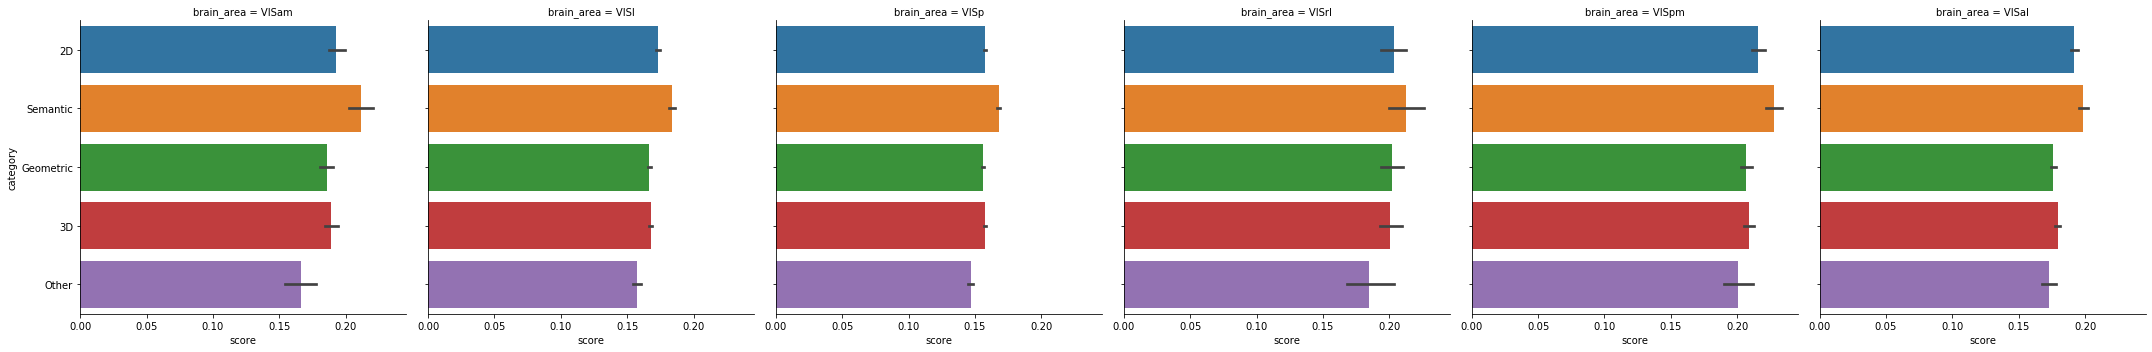

In [57]:
sns.catplot(x='score', y='category', kind='bar', col = 'brain_area', data=max_scores_task_plus);

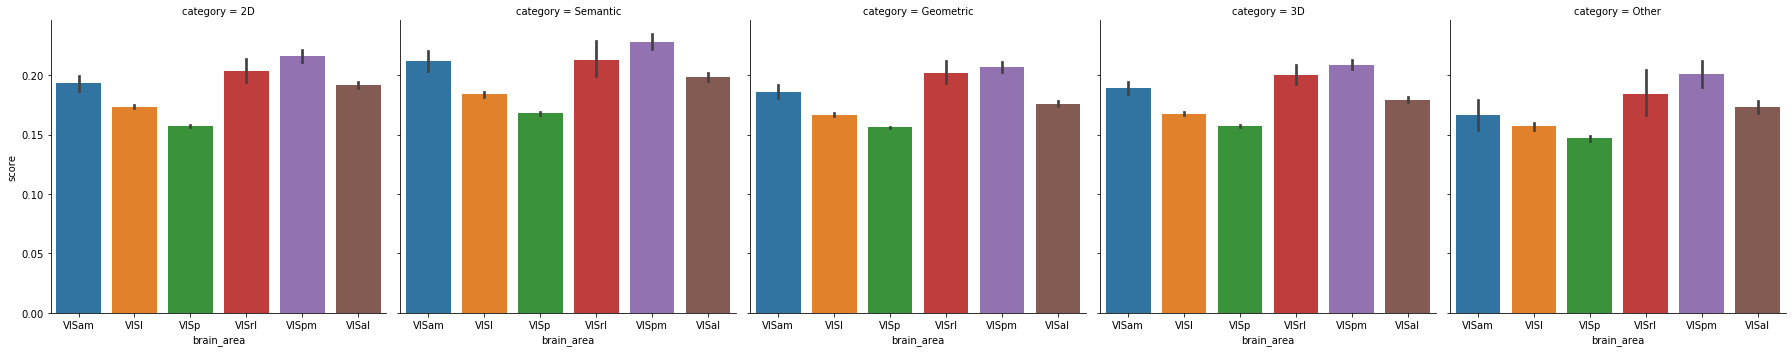

In [285]:
sns.catplot(x='brain_area', y='score', kind='bar', col = 'category', data=max_scores_task_plus);

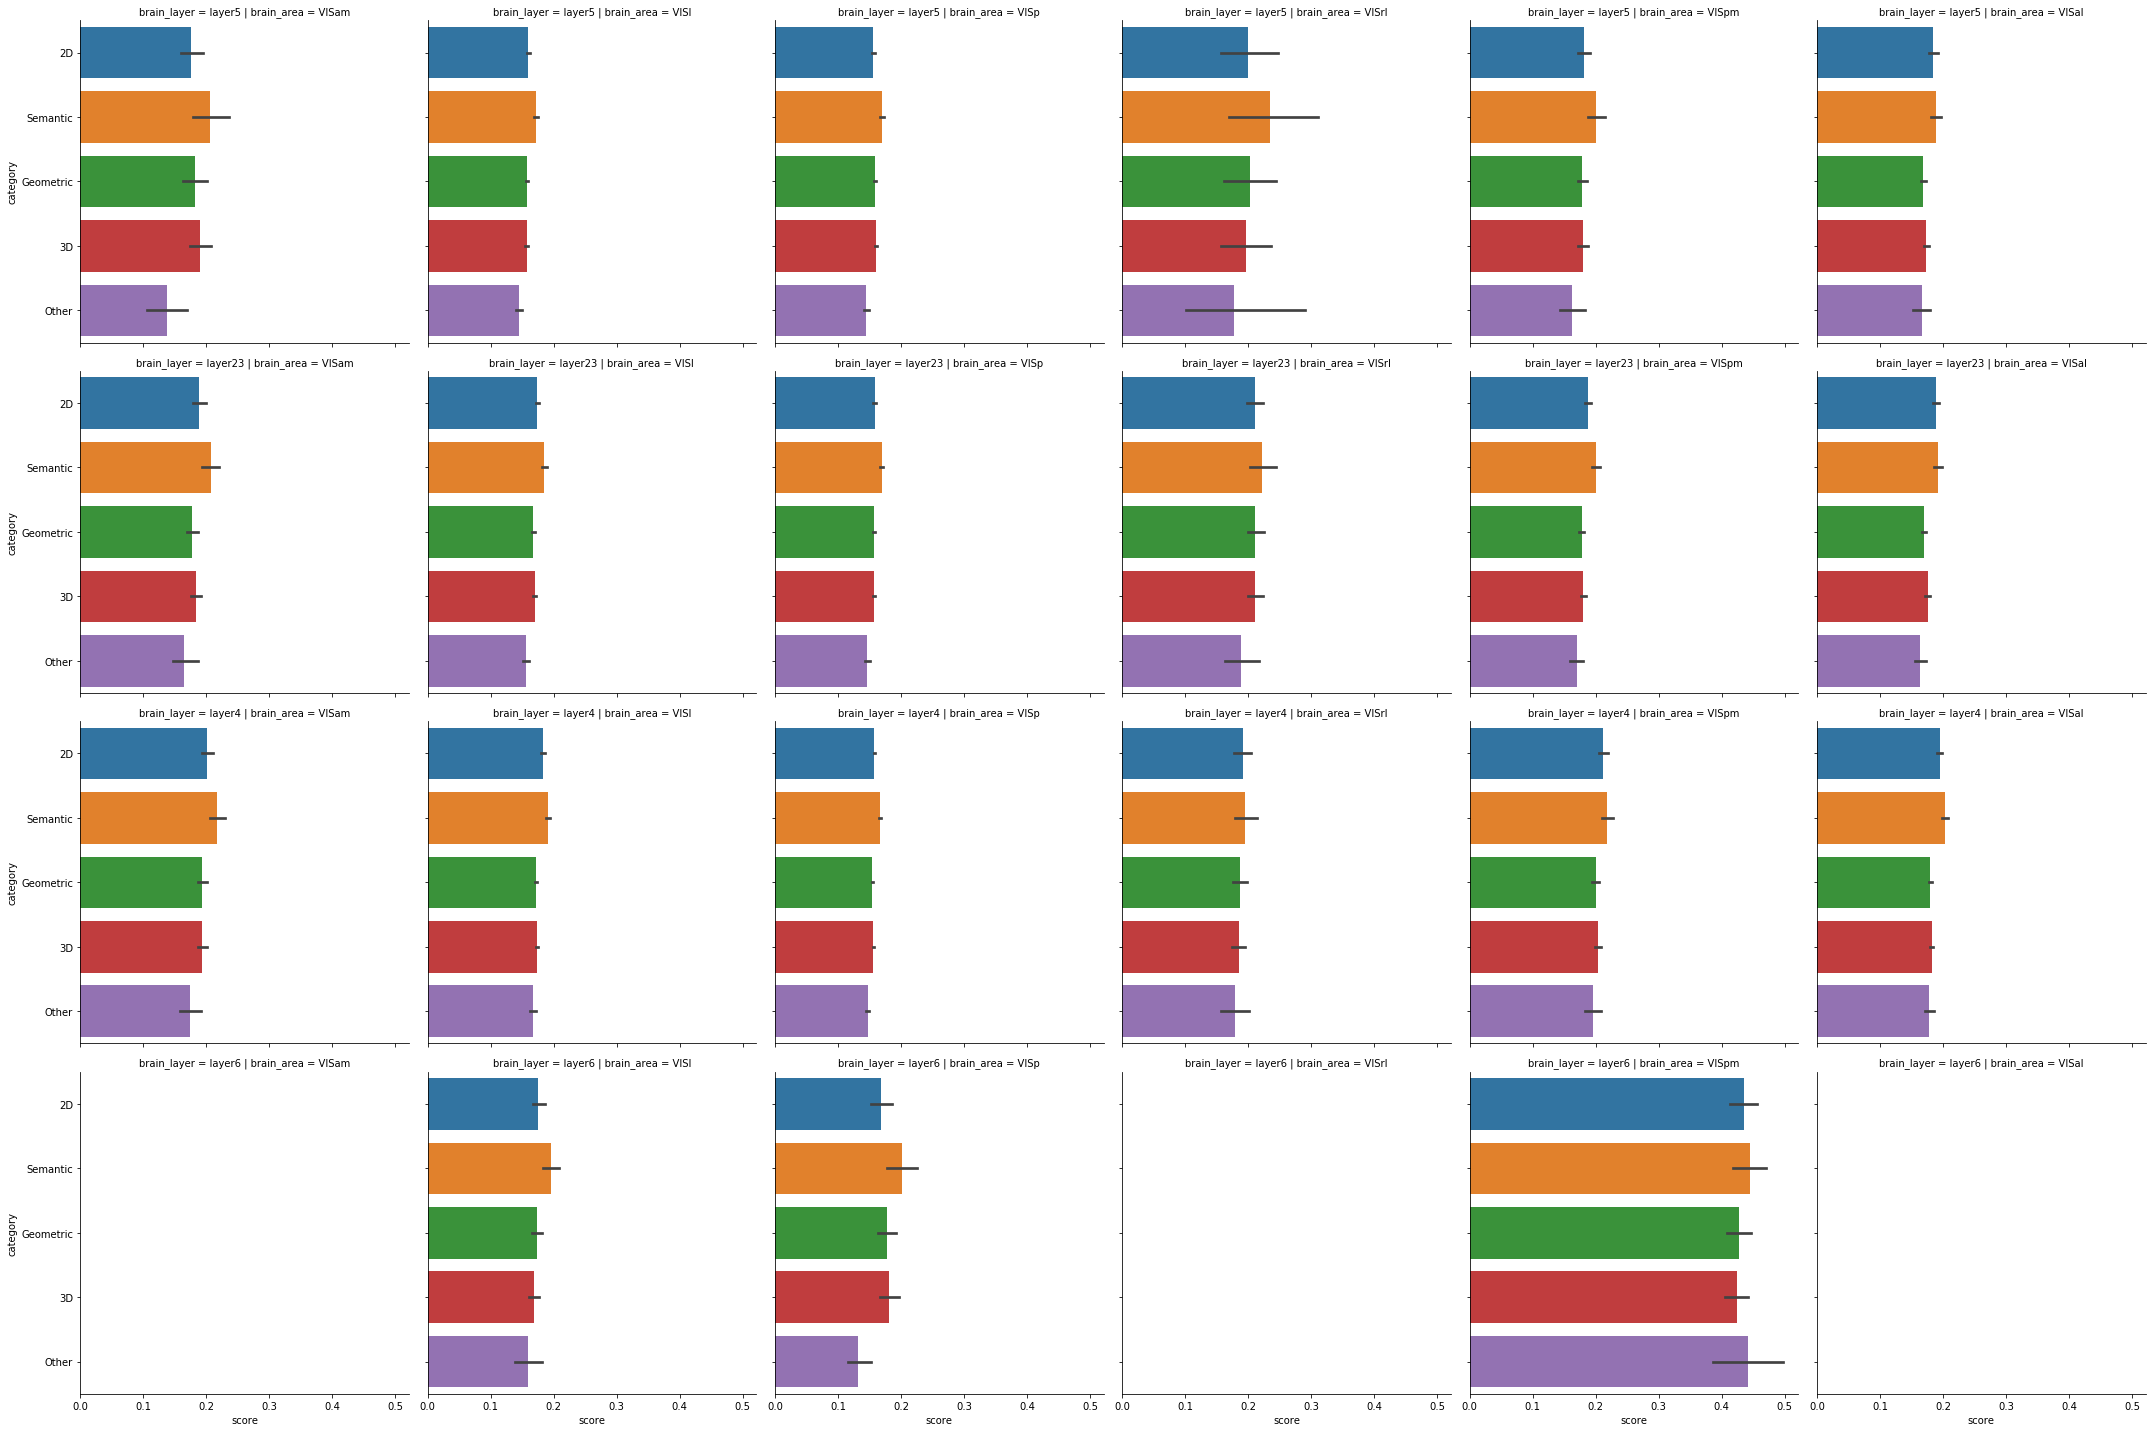

In [56]:
sns.catplot(x='score', y='category', kind='bar', col = 'brain_area', row = 'brain_layer', data=max_scores_task_plus);

### Max versus Mean Score Comparisons

In [ ]:
scores_by_site = (scoresheet.groupby(['brain_area', 'brain_layer', 'model', 'training', 'model_layer'])
                 ['score'].mean().reset_index())

In [ ]:
scores_by_site.groupby(['brain_area','brain_layer']).size().reset_index().rename(columns={0:'count'})

In [ ]:
scores_by_site_max = scores_by_site.groupby(['brain_area', 'brain_layer', 'model', 'training'])['score'].max().reset_index()
scores_by_site_mean = scores_by_site.groupby(['brain_area', 'brain_layer', 'model', 'training'])['score'].mean().reset_index()

In [ ]:
scores_by_site_max.sort_values(by='score', ascending=False)

In [ ]:
(scores_by_site_max.groupby(['brain_area','brain_layer','training']).mean().reset_index()
 .query("training == 'imagenet'")['score'].mean())

In [ ]:
(scores_by_site_max.groupby(['brain_area','brain_layer','training']).mean().reset_index()
 .query("training == 'random'")['score'].mean())

In [ ]:
pg.ttest(scores_by_site_max[scores_by_site_max['training'] == 'imagenet']['score'], 
         scores_by_site_max[scores_by_site_max['training'] == 'random']['score'])

In [ ]:
(scores_by_site_max.groupby(['model', 'training'])['score']
 .mean().reset_index().sort_values(by='score', ascending=False))

In [ ]:
pg.ttest((scores_by_site_max.groupby(['model', 'training'])['score']
          .mean().reset_index().query("training == 'imagenet'")['score']),
         (scores_by_site_max.groupby(['model', 'training'])['score']
          .mean().reset_index().query("training == 'random'")['score']))

In [ ]:
(scores_by_site_mean.groupby(['model', 'training'])['score'].mean()
 .reset_index().sort_values(by='score', ascending=False)).head()

In [ ]:
(scores_by_site_mean.groupby(['model', 'training'])['score'].mean()
 .reset_index().sort_values(by='score', ascending=False)).tail()

In [ ]:
scores_by_site_mean.sort_values(by='score', ascending=False)

In [ ]:
scores_by_site_max['model_string'] = scores_by_site_max['model'] + '_' + scores_by_site_max['training']

In [ ]:
scores_by_site_max['neural_site'] = scores_by_site_max['brain_area'] + '_' + scores_by_site_max['brain_layer']

In [ ]:
scores_by_site_max_taskonomy = scores_by_site_max.query("training == 'taskonomy'")

In [ ]:
scores_by_site_max_taskonomy

In [ ]:
scores_by_site_max_taskonomy.anova(dv="score", between=['model'])

In [ ]:
scores_by_site_max_taskonomy.anova(dv='score', between=['neural_site'])

In [ ]:
scores_by_site_max_taskonomy.anova(dv='score', between=['model','neural_site'])

In [ ]:
sns.catplot(x='score', y='model_string', kind='bar', #palette=sns.light_palette('navy'), 
            col = 'brain_area', row = 'brain_layer', data=scores_by_site_max);